In [154]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [155]:
from torch import nn

In [156]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor 
from torch.utils.data import DataLoader

<h3>Generating datapoints</h3>

In [184]:
# generating data points 

torch.manual_seed(42)

x_data = torch.randn(51)
n = 4
weights = torch.randn(5)
y_data = sum([weights[i] * x_data.pow(i) for i in range(n)]) 

x_data += torch.randn_like(x_data) * 0.2
y_data += torch.randn_like(y_data) * 0.2

size_train = int(0.7 * len(x_data))
rng = np.random.default_rng(seed = 42)
perm = rng.permutation(len(x_data))

train_x = x_data[perm[:size_train]]
train_y = y_data[perm[:size_train]]
test_x = x_data[perm[size_train:]]
test_y = y_data[perm[size_train:]]

print(train_x.shape)
print(test_x.shape)

torch.Size([35])
torch.Size([16])


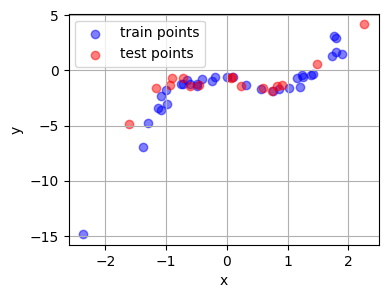

In [185]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)
ax.scatter(train_x,train_y,color = "blue",alpha = 0.5,label = "train points")
ax.scatter(test_x,test_y,color = "red",alpha = 0.5,label = "test points")
ax.legend()
plt.show()

<h3>Building dataset and dataloader</h3>

In [186]:
# customizing dataset

class PolyDS(Dataset):
    def __init__(self,x_data_set,y_data_set,transform = None,target_transform = None):
        assert len(x_data_set) == len(y_data_set), "input and target are not of the same size"
        self.points = x_data_set.reshape(-1,1)
        self.output_points = y_data_set.reshape(-1,1)
        self.transform = transform 
        self.target_transform = target_transform

    def get_data(self):
        return self.points, self.output_points

    def __len__(self):
        return len(self.points)

    def __getitem__(self, index):
        assert index < self.__len__(), "index out of range"
        x_point = self.points[index]
        y_point = self.output_points[index]
        if self.transform:
            x_point = self.transform(x_point)
        if self.target_transform:
            y_point = self.target_transform(y_point)
        return x_point,y_point

In [187]:
ds_train = PolyDS(train_x,train_y)
ds_test = PolyDS(test_x,test_y)

print("length of the datapoints train: ",ds_train.__len__())
print("5th element of the dataset train: ",ds_train.__getitem__(5))

print("length of the datapoints test: ",ds_test.__len__())
print("5th element of the dataset test: ",ds_test.__getitem__(5))

length of the datapoints train:  35
5th element of the dataset train:  (tensor([-0.6615]), tensor([-0.8845]))
length of the datapoints test:  16
5th element of the dataset test:  (tensor([0.2385]), tensor([-1.4230]))


In [188]:
train_dl = DataLoader(ds_train, batch_size = 5, shuffle = True)
test_dl = DataLoader(ds_test, batch_size = 5,shuffle = True)

In [189]:
# one could restore the dataset info form dataloader

print(train_dl.dataset.__len__())
print(test_dl.dataset.__len__())

35
16


<h3>Building model</h3>

In [190]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flattering_layer = nn.Flatten()
        self.inner_layers = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )
    
    def forward(self,x):
        x = self.flattering_layer(x)
        x = self.inner_layers(x)
        return x

In [191]:
def training_loop(dataload, model,loss,optimizer):
    size = dataload.dataset.__len__()

    for batch,(X,y) in enumerate(dataload):
        predict = model(X)
        loss_val = loss(predict,y)

        loss_val.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss_val = loss_val.item()
            step = batch + batch * len(X)
            #print(f"loss function value: {loss}, step: {step}/{size}")

def testing_loop(dataloader,model,loss):
    batches = len(dataloader)
    MSE = 0.
    for batch,(X,y) in enumerate(dataloader):
        with torch.no_grad():
            predict = model(X)
            MSE += loss(predict,y)
    #print(f"averaged MSE: {MSE / batches}")
    return MSE / batches

In [192]:
lr = 1e-3
epochs = 1001

model = LinearModel()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

for epoch in range(epochs):
    training_loop(train_dl,model,loss,optimizer)
    mse = testing_loop(test_dl,model,loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"mse value: {mse}")


Epoch 1/1001
mse value: 3.891815185546875
Epoch 101/1001
mse value: 2.7486231327056885
Epoch 201/1001
mse value: 2.153597116470337
Epoch 301/1001
mse value: 3.068326950073242
Epoch 401/1001
mse value: 1.2905484437942505
Epoch 501/1001
mse value: 1.1266024112701416
Epoch 601/1001
mse value: 2.1595041751861572
Epoch 701/1001
mse value: 1.0746451616287231
Epoch 801/1001
mse value: 1.0410091876983643
Epoch 901/1001
mse value: 1.0684123039245605
Epoch 1001/1001
mse value: 1.0533008575439453


In [193]:
xx = torch.arange(-2.7,2.7,0.1).reshape(-1,1)
with torch.inference_mode():
    pred = model(xx).flatten()
    

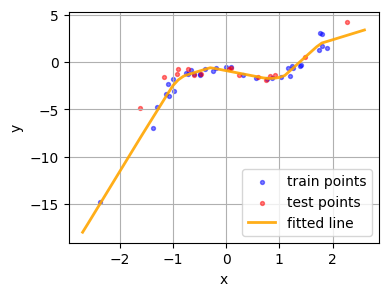

In [194]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)
ax.scatter(train_x,train_y,color = "blue",alpha = 0.5,s = 8,label = "train points")
ax.scatter(test_x,test_y,color = "red",alpha = 0.5,s = 8,label = "test points")
ax.plot(xx,pred,color = "orange",alpha = 0.9,lw = 2,label = "fitted line")
ax.legend()
plt.show()